This code has been forked from aaronisomaisom3 on Kaggle: https://www.kaggle.com/aaronisomaisom3
Original code is here: https://www.kaggle.com/code/aaronisomaisom3/backpack-xgboost-feature-engineering

In [1]:
# Import necessary modules
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, validation_curve, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import itertools

# Uncomment for hyperparameter tuning
# from xgbtune import tune_xgb_model

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [4]:
# Load the data
train = pd.read_csv("./inputs/train.csv", index_col='id')
train_extra = pd.read_csv("./inputs/training_extra.csv", index_col='id')
test = pd.read_csv('./inputs/test.csv', index_col='id')

# Combine train and train extra data sets into one
df = pd.concat([train, train_extra], axis=0, ignore_index=True)

# Rows and Cols
display(df.shape)
display(test.shape)

(3994318, 10)

(200000, 9)

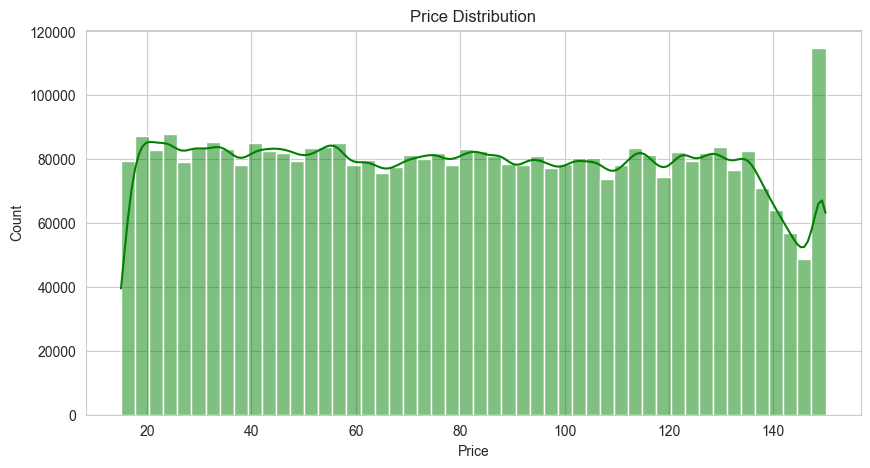

<Axes: xlabel='Weight Capacity (kg)', ylabel='Density'>

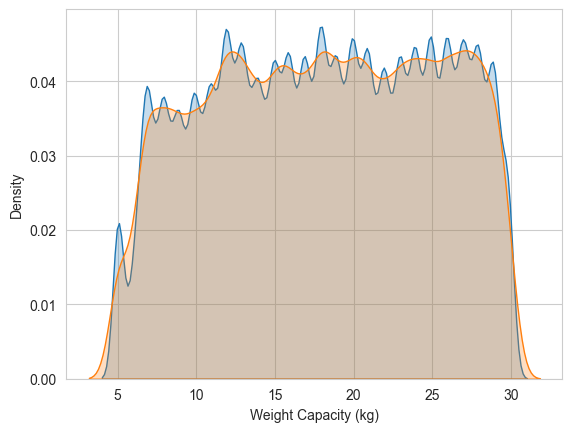

In [5]:
# Plot price distributions
plt.figure(figsize=(10, 5))
sns.histplot(df["Price"], bins=50, kde=True, color="green")
plt.title("Price Distribution")
plt.show()

# Compare distributions between train and test
sns.kdeplot(df['Weight Capacity (kg)'], label="Train", shade=True)
sns.kdeplot(test['Weight Capacity (kg)'], label="Test", shade=True)

In [6]:
# Drop the target Price column
X = df.drop(columns=['Price'])
y = df['Price']
display(X)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338
...,...,...,...,...,...,...,...,...,...
3994313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120
3994314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531
3994315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708
3994316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339


In [7]:
# Feature engineering function to determine better feature relationships/correlations.
def feature_engineering_xgb(X_train, y_train, test, cat_features, top_corr_features=5, max_new_features=10, k_best=10):
    """
    Enhances dataset by:
    1. Handling missing values.
    2. Encoding categorical features using CatBoostEncoder.
    3. Identifying top correlated numerical features with Price (train only).
    4. Generating limited interaction features (train & test).
    5. Removing duplicate features.
    6. Selecting the best features using SelectKBest.

    Parameters:
    - X_train: Training Feature DataFrame
    - y_train: Training target variable (Price)
    - test: Test Feature DataFrame (no y (Price) available)
    - cat_features: List of categorical feature names
    - top_corr_features: Number of top correlated numerical features to use in interactions
    - max_new_features: Maximum number of new features to generate
    - k_best: Number of top features to select with SelectKBest

    Returns:
    - Transformed `X_train` and `test` DataFrames with engineered features.
    - List of selected features from training data.
    """

    # Copy data to prevent modification
    X_train = X_train.copy()
    test = test.copy()

    print("\n🛠️ Handling Missing Values...")

    # Show NaN counts before handling
    print("\n🔍 NaN Counts Before Handling:")
    print("Training Data:\n", X_train.isna().sum().sort_values(ascending=False).head(10))
    print("Test Data:\n", test.isna().sum().sort_values(ascending=False).head(10))

    # Fill categorical NaN with "Unknown" (Train & Test)
    X_train[cat_features] = X_train[cat_features].fillna("Unknown")
    test[cat_features] = test[cat_features].fillna("Unknown")

    # Log Transformation (Train & Test)
    X_train['Weight Capacity (kg)'] = X_train['Weight Capacity (kg)'].fillna(X_train['Weight Capacity (kg)'].mean())
    X_train['Compartments'] = X_train['Compartments'].fillna(X_train['Compartments'].mean())

    test['Weight Capacity (kg)'] = test['Weight Capacity (kg)'].fillna(test['Weight Capacity (kg)'].mean())
    test['Compartments'] = test['Compartments'].fillna(test['Compartments'].mean())

    # Show NaN counts after handling
    print("\n✅ NaN Counts After Handling:")
    print("Training Data:\n", X_train.isna().sum().sort_values(ascending=False).head(10))
    print("Test Data:\n", test.isna().sum().sort_values(ascending=False).head(10))
    print("✅ Filled missing values in categorical and numerical features.")

    # Step 2: Encode Categorical Features Using CatBoostEncoder
    print("\n🔢 Applying CatBoost Encoding to Categorical Features...")
    encoder = CatBoostEncoder(cols=cat_features, random_state=42)
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    test_encoded = encoder.transform(test)

    print(f"✅ CatBoost Encoded {len(cat_features)} categorical features.")

    # Step 3: Compute Correlations (Train Only)
    corr_matrix = X_train_encoded.corrwith(y_train).abs().sort_values(ascending=False)
    print("\n🔍 Top 10 Features Most Correlated with Price:\n", corr_matrix.head(10))

    # Select top correlated numerical features for interactions (Train Only)
    top_features = corr_matrix.head(top_corr_features).index.tolist()
    numeric_cols = X_train_encoded[top_features].select_dtypes(include=[np.number]).columns.tolist()

    # Step 4: Generate LIMITED Interaction Features (Train & Test)
    print("\n⚙️ Generating Limited Interaction Features...")
    new_features = []
    interaction_count = 0  # Track number of generated features

    for col1, col2 in itertools.combinations(numeric_cols, 2):
        if interaction_count >= max_new_features:
            break  # Stop generating new features if max_new_features is reached

        X_train_encoded[f"{col1}_x_{col2}"] = X_train_encoded[col1] * X_train_encoded[col2]
        X_train_encoded[f"{col1}_div_{col2}"] = X_train_encoded[col1] / (X_train_encoded[col2] + 1e-6)  # Avoid division by zero
        test_encoded[f"{col1}_x_{col2}"] = test_encoded[col1] * test_encoded[col2]
        test_encoded[f"{col1}_div_{col2}"] = test_encoded[col1] / (test_encoded[col2] + 1e-6)

        new_features.extend([f"{col1}_x_{col2}", f"{col1}_div_{col2}"])
        interaction_count += 2

    print(f"✅ Created {interaction_count} new interaction features.")

    # Step 5: Remove Duplicate Features (Train & Test)
    print("\n🗑️ Removing Duplicate Features...")
    X_train_encoded = X_train_encoded.loc[:, ~X_train_encoded.columns.duplicated()]
    test_encoded = test_encoded.loc[:, ~test_encoded.columns.duplicated()]
    print(f"✅ Removed duplicate features. Remaining Train Features: {X_train_encoded.shape[1]}, Test Features: {test_encoded.shape[1]}")

    # Step 6: Feature Selection Using SelectKBest
    print("\n🔍 Selecting Best Features Using SelectKBest...")
    selector = SelectKBest(score_func=f_regression, k=k_best)
    X_train_selected = selector.fit_transform(X_train_encoded, y_train)
    test_selected = selector.transform(test_encoded)
    selected_features = X_train_encoded.columns[selector.get_support()].tolist()
    print(f"\n🎯 Selected Top {len(selected_features)} Features Based on SelectKBest:")
    print(selected_features, "\n\n")

    # Convert to DataFrame
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train_encoded.index)
    test_selected = pd.DataFrame(test_selected, columns=selected_features, index=test_encoded.index)

    return X_train_selected, test_selected, selected_features

In [8]:
# Function to find the best hyperparameters to tune the XGBRegressor.
def randomized_grid_search(X_train, y_train):
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    params = {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.25, 0.1],
        'max_depth': [1, 3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.4, 0.6, 0.8],
        'colsample_bytree': [0.5, 0.8, 0.9],
        'reg_lambda': [0, 1, 5, 10],
        'min_split_loss': [0, 0.1, 0.5, 1, 3, 5, 10],
        'reg_alpha': [0, 0.1, 1]
    }

    grid_search = RandomizedSearchCV(xgb, params, cv=5, random_state=42,
                                     scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_

# Do a random grid search to understand the impact of the hyperparameters.
# Commented out since this takes LOTS of time.
# randomized_grid_search(X_train, y_train)

In [9]:
cat_features = ['Size', 'Brand', 'Material', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']
X_train_transformed, X_test_transformed, selected_features = feature_engineering_xgb(X, y, test, cat_features)

X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, y, test_size=0.2, random_state=42, shuffle=True)

best_params = {'eval_metric': 'rmsle', 'tree_method': 'hist', 'max_depth': 8, 'min_child_weight': 2,
               'subsample': 0.8, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0, 'random_state': 42}

# Run XGB given the tuned parameters
xgb_boost = XGBRegressor(early_stopping_rounds=100, **best_params)

xgb_boost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)
print(f"Best XGBoost iteration using RMSE: {xgb_boost.best_iteration} \n")

y_pred = xgb_boost.predict(X_test)

# Compare MAE & RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.4f}")


🛠️ Handling Missing Values...

🔍 NaN Counts Before Handling:
Training Data:
 Color                   133617
Brand                   126758
Material                110962
Style                   104180
Laptop Compartment       98533
Waterproof               94324
Size                     87785
Weight Capacity (kg)      1808
Compartments                 0
dtype: int64
Test Data:
 Color                   6785
Brand                   6227
Material                5613
Style                   5153
Laptop Compartment      4962
Waterproof              4811
Size                    4381
Weight Capacity (kg)      77
Compartments               0
dtype: int64

✅ NaN Counts After Handling:
Training Data:
 Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
dtype: int64
Test Data:
 Brand                   0
Material     

In [10]:
# Try CatBoost for comparison
#cbr = CatBoostRegressor(iterations=500,
#                        depth=5,
#                        learning_rate=0.3,
#                        loss_function='RMSE',
#                        random_state=42)

#cbr.fit(X_train_encoded, y_train, eval_set=[(X_test_encoded, y_test)], verbose=200)
#y_pred = cbr.predict(X_test_encoded)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print(f"CatBoost Root Mean Squared Error (RMSE): {rmse}")

In [11]:
# Handle the prediction and submission file generation
test_pred = xgb_boost.predict(X_test_transformed)

submission = pd.read_csv('./inputs/sample_submission.csv')
submission = pd.DataFrame({'id': submission.id, 'Price': test_pred})
submission.to_csv('./outputs/submission.csv', index=False)
display(submission)

,id,Price
0,300000,81.917892
1,300001,82.273186
2,300002,83.588356
3,300003,81.183731
4,300004,77.134056
...,...,...
199995,499995,80.367218
199996,499996,79.845848
199997,499997,82.686882
199998,499998,81.180275
